# Trabalho Prático 5 - Processamento de Imagens Coloridas

<b>1) Escolha uma aplicação e utilize processamento em pseudocores a partir do fatiamento de intensidade. Justifique o uso das cores para o problema em questão.</b>

In [1]:
from skimage.io import imread,imsave, imshow
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import math
import numpy as np

<i><b>Justificativa:</b> A aplicação escolhida foi a análise de lesões de pele para detecção de melanoma. A partir do fatiamento de cores, foi possível separar a lesão da pele e destacar as regiões que demonstram ser suspeitas da existência de um melanoma. O plot abaixo apresenta a separação das instensidades e uma legenda explicativa sobre as regiões destacadas.</i>

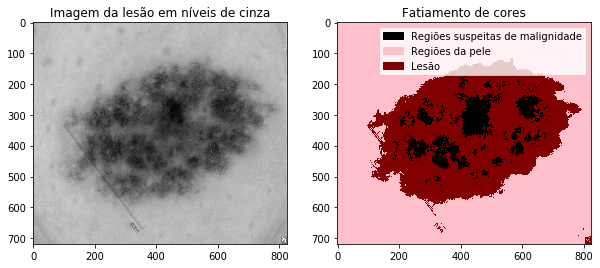

In [2]:
lesion = imread('ISIC_0000550.jpg')
new = lesion.copy()
lesion = (rgb2gray(lesion)*255).astype(int)
for i in range(lesion.shape[0]):
    for j in range(lesion.shape[1]):
            if(lesion[i][j] >= 0) and (lesion[i][j] <= 60):
                new[i, j] = [0,0,0]
            elif(lesion[i][j] >= 150) and (lesion[i][j] <= 220):
                new[i, j] = [255,192,203]
            else:
                new[i, j] = [128,0,0]
                
red_patch = mpatches.Patch(color='black', label='Regiões suspeitas de malignidade')
pink_patch = mpatches.Patch(color='pink', label='Regiões da pele')
maroon_patch = mpatches.Patch(color='maroon', label='Lesão')

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(lesion, cmap='gray')
ax[0].set_title('Imagem da lesão em níveis de cinza')
ax[1].imshow(new)
ax[1].set_title('Fatiamento de cores')
ax[1].legend(handles=[red_patch,pink_patch,maroon_patch])

<b>2) Adapte o algoritmo da atividade prática de convolução para processar imagens coloridas.</b>

In [3]:
def zero(imagem, filtro):
    l = filtro.shape[0]//2
    c = filtro.shape[1]//2
    
    new_img = np.zeros((filtro.shape[0]//2*2 + imagem.shape[0], filtro.shape[1]//2*2 + imagem.shape[1], 3), 'uint8')
    new_img[l:l+imagem.shape[0], c:c+imagem.shape[1]] = imagem.copy()
    
    img = np.zeros(new_img.shape)
    
    for i in range(l, new_img.shape[0]-l):
        for j in range(c, new_img.shape[1]-c):
            corte = new_img[i-l:i+l+1, j-c:j+c+1]
            mult = corte*filtro
            img[i][j] = [mult[:,:,0].sum(), mult[:,:,1].sum(), mult[:,:,2].sum()]
    return img[l:l+imagem.shape[0], c:c+imagem.shape[1]]

In [4]:
def normalizar(img):
    img_max = img.max()
    img_min = img.min()
    
    img = ((img - img_min)/(img_max - img_min))*255
            
    return img

Text(0.5, 1.0, 'Convolução')

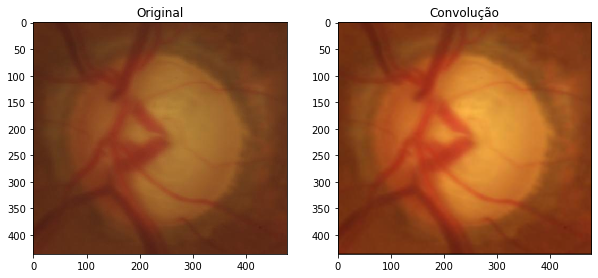

In [5]:
filtro = np.array([[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]])
img = imread('retina/deep/Im002.bmp')
result = zero(img, filtro)
result = normalizar(result).astype(int)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(result)
ax[1].set_title('Convolução')

<b>3) Aplique os algoritmos criados na atividade prática de segmentação em diferentes modelos de cores:
* Utilize pelo menos 3 modelos de cores;
* Deverão ser criados testes para cada componente de cor do modelo;
* Utilize a base de imagens "retina.zip".</b>

<i><b>Obs.: </b>Os modelos de cores utilizados foram o CMY, o HSV e o YUV. Os algoritmos de segmentação foram o Kmeans, o Otsu e o MiniBatch, executados para toda a base. Na atividade passada, usei o Slic como algoritmo alternativo, mas tive que trocar nessa ativida porque o Slic não estava funcionando nos modelos de cores diferentes do RGB. A métrica de validação escolhida foi a acurácia e os resultados foram apresentados na tabela da penúltima célula.<i/>

HSV

In [6]:
def rgb_to_hsv(img):
    
    img = img/255.0
    hsv = np.zeros((img.shape[0], img.shape[1], 3))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            R, G, B = img[i,j]
            mx = max(R, G, B)
            mn = min(R, G, B)
    
            delta = mx-mn
            h = 0
            if delta == 0:
                h = 0
            elif mx == R:
                #h = (60 * ((g-b)/delta) + 360) % 360
                h = (((G-B)/delta) % 6)
            elif mx == G:
                #h = (60 * ((b-r)/delta) + 120) % 360
                h = (((B-R)/delta) + 2)
            elif mx == B:
                #h = (60 * ((r-g)/delta) + 240) % 360
                h = (((R-G)/delta) + 4)
            if mx == 0:
                s = 0
            else:
                s = delta/mx
            v = mx
            hsv[i, j] = np.asarray([h, s, v])
    
    return hsv

CMY

In [7]:
def rgb_to_cmy(img):
    cmy = np.zeros(img.shape)
    cmy = 1 - img
    return cmy

CMYK

In [8]:
def rgb_to_cmyk(img):
    cmyk = np.zeros(img.shape)
    cmyk = 255 - img
    k = cmyk.min()
    cmyk[:,:,0] = 255*((cmyk[:,:,0] - k)/(255 - k))
    cmyk[:,:,1] = 255*((cmyk[:,:,1] - k)/(255 - k))
    cmyk[:,:,2] = 255*((cmyk[:,:,2] - k)/(255 - k))
    return cmyk

YUV

In [9]:
def rgb_to_yuv(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    Y =  0.299*R/255. + 0.587*G/255. + 0.114*B/255.
    U = -0.147*R/255. - 0.289*G/255. + 0.436*B/255.
    V =  0.615*R/255. - 0.515*G/255. - 0.100*B/255.

    YUV=np.zeros(img.shape)
    YUV[:,:,0]=Y
    YUV[:,:,1]=U
    YUV[:,:,2]=V
    return YUV

Algoritmos de segmentação

In [10]:
from skimage.io import imread, imsave, imshow, imread_collection
from skimage.color import rgb2gray
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from skimage.filters import threshold_otsu
from skimage.segmentation import slic
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score
import glob as g
from tqdm import tqdm
import csv
import pandas as pd

In [11]:
def aplicaKmeans(img):
    img = rgb2gray(img)
    X = img.reshape((-1, 1))
    k_means = KMeans(n_clusters=2)
    _ = k_means.fit(X)
    X_clustered = k_means.labels_
    centers = k_means.cluster_centers_.reshape(-1)
    labels = [0., 1.]
    if(centers[0] > centers[1]):
        labels = labels[::-1]
    #X_clustered = X_clustered.reshape(img.shape)
    new_img = np.choose(X_clustered, labels).reshape(img.shape)
    return new_img

def aplicaOtsu(img):
    img = rgb2gray(img)
    thresh = threshold_otsu(img)
    binary = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i][j] > thresh):
                binary[i][j] = 1
            else:
                binary[i][j] = 0
    return binary

def aplicaSuperpixel(img):
    segments = slic(img, n_segments=2, sigma = 5)
    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            if(segments[i][j] == 1):
                segments[i][j] = 0
            else:
                segments[i][j] = 255
    return segments

def aplicaMiniBatch(img):

    kmeans = MiniBatchKMeans(n_clusters=2)
    imgs_mini_seg = []
    img_gray = rgb2gray(img)
    X = img_gray.reshape((-1, 1))
    kmeans.fit(X)
    values = kmeans.cluster_centers_.squeeze()
    labels = kmeans.labels_
    values = values > values.min()
    seg_img = np.choose(labels, values)
    seg_img.shape = img_gray.shape
        
    return seg_img

In [12]:
retinas = g.glob('retina/deep/*.bmp')

In [13]:
acc_cmy = [[0,0,0], [0,0,0], [0,0,0]]
acc_hsv = [[0,0,0], [0,0,0], [0,0,0]]
acc_yuv = [[0,0,0], [0,0,0], [0,0,0]]

<i>Calculando segmentação pro modelo CMY<i/>

In [14]:
for i in tqdm(range(len(retinas))):
    name = retinas[i].split('/')[-1].split('.')[0]
    img = imread(retinas[i])
    mask = imread('retina/mask_deep/'+name+'-exp1.bmp')
    
    img_true=np.array(mask).ravel()
    
    cmy = rgb_to_cmy(img)
    
    #CMY - kmeans
    kmeans1 = aplicaKmeans(cmy[:,:,0])
    kmeans2 = aplicaKmeans(cmy[:,:,1])
    kmeans3 = aplicaKmeans(cmy[:,:,2])
    
    img_pred=np.array(kmeans1).ravel()
    acc_cmy[0][0] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(kmeans2).ravel()
    acc_cmy[0][1] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(kmeans3).ravel()
    acc_cmy[0][2] += accuracy_score(img_true, img_pred)
    
    #CMY - Otsu
    otsu1 = aplicaOtsu(cmy[:,:,0])
    otsu2 = aplicaOtsu(cmy[:,:,1])
    otsu3 = aplicaOtsu(cmy[:,:,2])
    
    img_pred=np.array(otsu1).ravel()
    acc_cmy[1][0] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(otsu2).ravel()
    acc_cmy[1][1] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(otsu3).ravel()
    acc_cmy[1][2] += accuracy_score(img_true, img_pred)
    
    #CMY - MiniBatchKmeans
    mini1 = aplicaMiniBatch(cmy[:,:,0])
    mini2 = aplicaMiniBatch(cmy[:,:,1])
    mini3 = aplicaMiniBatch(cmy[:,:,2])
    
    img_pred=np.array(mini1).ravel()
    acc_cmy[2][0] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(mini2).ravel()
    acc_cmy[2][1] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(mini3).ravel()
    acc_cmy[2][2] += accuracy_score(img_true, img_pred)

100%|██████████| 14/14 [01:34<00:00,  7.58s/it]


<i>Calculando segmentação pro modelo HSV<i/>

In [15]:
for i in tqdm(range(len(retinas))):
    name = retinas[i].split('/')[-1].split('.')[0]
    img = imread(retinas[i])
    mask = imread('retina/mask_deep/'+name+'-exp1.bmp')
    
    img_true=np.array(mask).ravel()
    
    hsv = rgb_to_hsv(img)
    
    #HSV - kmeans
    kmeans1 = aplicaKmeans(hsv[:,:,0])
    kmeans2 = aplicaKmeans(hsv[:,:,1])
    kmeans3 = aplicaKmeans(hsv[:,:,2])
    
    img_pred=np.array(kmeans1).ravel()
    acc_hsv[0][0] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(kmeans2).ravel()
    acc_hsv[0][1] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(kmeans3).ravel()
    acc_hsv[0][2] += accuracy_score(img_true, img_pred)
    
    #HSV - Otsu
    otsu1 = aplicaOtsu(hsv[:,:,0])
    otsu2 = aplicaOtsu(hsv[:,:,1])
    otsu3 = aplicaOtsu(hsv[:,:,2])
    
    img_pred=np.array(otsu1).ravel()
    acc_hsv[1][0] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(otsu2).ravel()
    acc_hsv[1][1] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(otsu3).ravel()
    acc_hsv[1][2] += accuracy_score(img_true, img_pred)
    
    #HSV - MiniBatchKmeans
    mini1 = aplicaMiniBatch(hsv[:,:,0])
    mini2 = aplicaMiniBatch(hsv[:,:,1])
    mini3 = aplicaMiniBatch(hsv[:,:,2])
    
    img_pred=np.array(mini1).ravel()
    acc_hsv[2][0] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(mini2).ravel()
    acc_hsv[2][1] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(mini3).ravel()
    acc_hsv[2][2] += accuracy_score(img_true, img_pred)

100%|██████████| 14/14 [02:02<00:00, 10.19s/it]


<i>Calculando segmentação pro modelo YUV<i/>

In [17]:
for i in tqdm(range(len(retinas))):
    name = retinas[i].split('/')[-1].split('.')[0]
    img = imread(retinas[i])
    
    mask = imread('retina/mask_deep/'+name+'-exp1.bmp')
    img_true=np.array(mask).ravel()
    
    yuv = rgb_to_yuv(img)
    
    #YUV - kmeans
    kmeans1 = aplicaKmeans(yuv[:,:,0])
    kmeans2 = aplicaKmeans(yuv[:,:,1])
    kmeans3 = aplicaKmeans(yuv[:,:,2])
    
    img_pred=np.array(kmeans1).ravel()
    acc_yuv[0][0] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(kmeans2).ravel()
    acc_yuv[0][1] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(kmeans3).ravel()
    acc_yuv[0][2] += accuracy_score(img_true, img_pred)
    
    #YUV - Otsu
    otsu1 = aplicaOtsu(yuv[:,:,0])
    otsu2 = aplicaOtsu(yuv[:,:,1])
    otsu3 = aplicaOtsu(yuv[:,:,2])
    
    img_pred=np.array(otsu1).ravel()
    acc_yuv[1][0] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(otsu2).ravel()
    acc_yuv[1][1] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(otsu3).ravel()
    acc_yuv[1][2] += accuracy_score(img_true, img_pred)
    
    #YUV - MiniBatchKmeans
    mini1 = aplicaMiniBatch(yuv[:,:,0])
    mini2 = aplicaMiniBatch(yuv[:,:,1])
    mini3 = aplicaMiniBatch(yuv[:,:,2])
    
    img_pred=np.array(mini1).ravel()
    acc_yuv[2][0] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(mini2).ravel()
    acc_yuv[2][1] += accuracy_score(img_true, img_pred)
    
    img_pred=np.array(mini3).ravel()
    acc_yuv[2][2] += accuracy_score(img_true, img_pred)

100%|██████████| 14/14 [01:19<00:00,  6.51s/it]


In [18]:
#Calculando a média
qtd = len(retinas)

cmy = acc_cmy
hsv = acc_hsv
yuv = acc_yuv

for i in range(len(acc_cmy)):
    for j in range(len(acc_cmy[i])):
        acc_cmy[i][j] /= qtd
        acc_hsv[i][j] /= qtd
        acc_yuv[i][j] /= qtd

In [19]:
df = pd.DataFrame({'Canal': ['C', 'M', 'Y', ' ', 'H', 'S', 'V', ' ', 'Y', 'U', 'V'],
                    'Kmeans': [acc_cmy[0][0], acc_cmy[0][1], acc_cmy[0][2], ' ', acc_hsv[0][0], acc_hsv[0][1], acc_hsv[0][2], ' ', acc_yuv[0][0], acc_yuv[0][1], acc_yuv[0][2]],
                    'Otsu': [acc_cmy[1][0], acc_cmy[1][1], acc_cmy[1][2], ' ', acc_hsv[1][0], acc_hsv[1][1], acc_hsv[1][2], ' ', acc_yuv[1][0], acc_yuv[1][1], acc_yuv[1][2]],
                    'MiniBatch': [acc_cmy[2][0], acc_cmy[2][1], acc_cmy[2][2], ' ', acc_hsv[2][0], acc_hsv[2][1], acc_hsv[2][2], ' ', acc_yuv[2][0], acc_yuv[2][1], acc_yuv[2][2]]})

In [20]:
df.to_csv(index=False)
df

,Canal,Kmeans,Otsu,MiniBatch
0,C,0.217153,0.218505,0.220306
1,M,0.0586561,0.0578003,0.0611684
2,Y,0.0409011,0.0409011,0.0402926
3,,,,
4,H,0.597597,0.598954,0.57255
5,S,0.173961,0.170952,0.175933
6,V,0.50971,0.503059,0.506041
7,,,,
8,Y,0.610472,0.608351,0.606623
9,U,0.252375,0.254494,0.249516


<b>Melhor resultado: 0.610472 => componente C do modelo CMY, na segmentação pelo Otsu.</b>